# SUSTAV ZA DETEKCIJU KARAKTERISTIČNIH TOČAKA LICA
Toni Polanec 2023.


In [2]:

import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import seaborn as sns

import random

from tqdm.keras import TqdmCallback
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from keras.initializers import glorot_uniform, he_uniform
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam
import pickle


## Analiza podataka

In [3]:
# učitanje slika
face_images = np.load('face_images.npz')
faces=face_images.get(face_images.files[0]) 

# oblikovanje polja
faces=np.moveaxis(faces,-1,0)
faces=faces.reshape(faces.shape[0],faces.shape[1],faces.shape[1],1)

In [4]:
faces.shape

(7049, 96, 96, 1)

Ukupno imamo **7049** različitih slika.  
Svaka slika je veličine **96x96** piksela. 


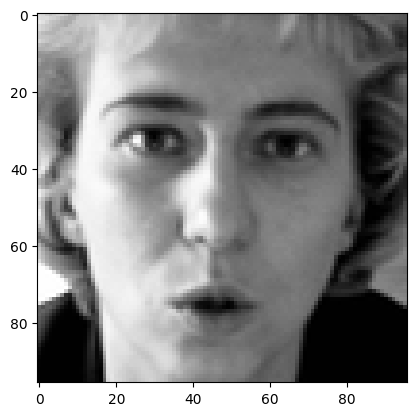

In [5]:
plt.imshow(faces[1], cmap='gray')

^ primjer slike

In [6]:
# čitanje datoteke s karakterističnim točkama lica
landmarks = pd.read_csv('facial_keypoints.csv')
landmarks.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


Korišteni dataset ima sveukupno 15 karakterističnih točaka lica.  
U ovom radu koristit ćemo samo 9 točaka, i to:
- centar lijevog oka
- lijevi rub lijevog oka
- desni rub desnog oka

- centar desnog oka
- lijevi rub desnog oka
- desni rub desnog oka
  
- vrh nosa
  
- centar gornje usne
- centar donje usne

In [7]:
# brisanje podataka o obrvama i ustima (osim bottom_lip_center)
landmarks = landmarks.drop(['left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y'], axis=1)

In [8]:
landmarks.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,nose_tip_x,nose_tip_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,44.420571,57.066803,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,48.206298,55.660936,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,47.557263,53.538947,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,51.885078,54.166539,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,43.299534,64.889521,44.962748,73.707387,44.227141,86.871166


In [9]:
landmarks.shape

(7049, 18)

Za svaku sliku imamo 18 parametara koji predstavljaju koordinate 9 različitih točaka na licu (x,y).  
<br>
Zbog nepravilnosti dataseta moramo provjeriti koliko ima nepostojećih vrijednosti.

In [10]:
# provjera koliko null vrijednosti imamo u svakom stupcu
landmarks.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
nose_tip_x                      0
nose_tip_y                      0
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_bottom_lip_y      33
dtype: int64

Vidimo da ih ima dosta pa ćemo to sanirati u sljedećim koracima.

#### Prikaz tablice korelacije između karakterističnih točaka lica:

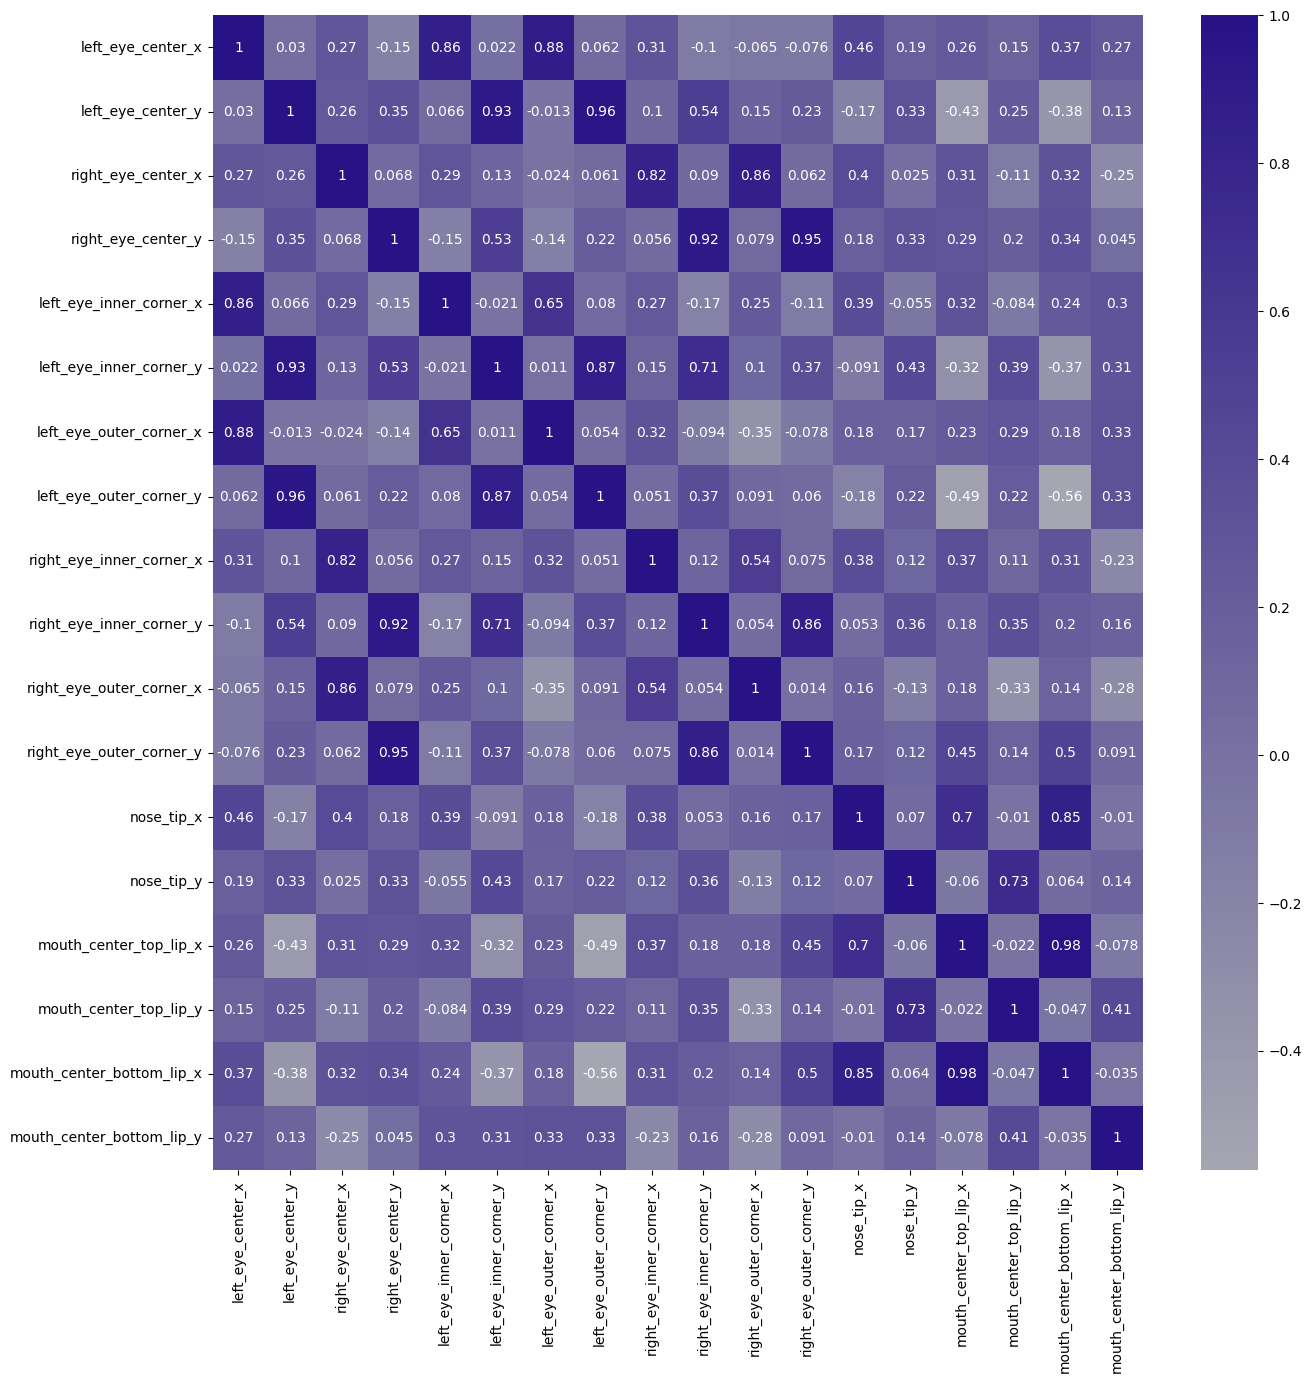

In [11]:
landmarks_correlation = landmarks.corr()

plt.figure(figsize=(15,15))
sns.heatmap(landmarks_correlation, cmap=sns.color_palette("blend:#A5A6B1,#271286", as_cmap=True), annot=True)
plt.show()


Po grafu iznad vidimo da imamo korelacije između nekih točaka u datasetu. Npr. *right_eye_center_x* i *right_eye_outer_corner_x* imaju korelaciju od 0.86.  
To ćemo iskoristiti da popunimo null vrijednosti u datasetu.  
<br>
Npr. uz pomoć točke centra oka ćemo izračunati točke vanjskog i unutarnjeg ruba oka.



## Predprocesiranje podataka

Po analizi podataka dobili smo informaciju da za karakterističnu točku *eye_center* fali samo 13 vrijednosti. Pa umijesto da izmišljam vrijednosti za te točke, odlučio sam ih izbaciti iz dataseta.



In [12]:
empty_rows = landmarks[['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y']].isnull().any(axis=1)
null_indexes = landmarks[empty_rows].index

# brisanje slika koje imaju te određene točke s null vrijednostima
faces = np.delete(faces, null_indexes, axis=0)
landmarks = landmarks.dropna(subset=['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y'], how='any')


print("landmarks.shape ->", landmarks.shape)
print("faces.shape ->", faces.shape)
# provjera koliko null vrijednosti imamo u svakom stupcu
landmarks.isnull().sum()




landmarks.shape -> (7033, 18)
faces.shape -> (7033, 96, 96, 1)


left_eye_center_x               0
left_eye_center_y               0
right_eye_center_x              0
right_eye_center_y              0
left_eye_inner_corner_x      4773
left_eye_inner_corner_y      4773
left_eye_outer_corner_x      4776
left_eye_outer_corner_y      4776
right_eye_inner_corner_x     4771
right_eye_inner_corner_y     4771
right_eye_outer_corner_x     4771
right_eye_outer_corner_y     4771
nose_tip_x                      0
nose_tip_y                      0
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_bottom_lip_y      33
dtype: int64

Isto tako za *mouth_center_bottom_lip* fali 33 vrijednosti, pa ćemo i njih izbaciti iz dataseta.


In [13]:
empty_rows = landmarks[['mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y']].isnull().any(axis=1)
null_indexes = landmarks[empty_rows].index

# brisanje slika koje imaju te određene točke s null vrijednostima
faces = np.delete(faces, null_indexes, axis=0)
landmarks = landmarks.dropna(subset=['mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y'], how='any')

print("landmarks.shape ->", landmarks.shape)
print("faces.shape ->", faces.shape)
# provjera koliko null vrijednosti imamo u svakom stupcu
landmarks.isnull().sum()

landmarks.shape -> (7000, 18)
faces.shape -> (7000, 96, 96, 1)


left_eye_center_x               0
left_eye_center_y               0
right_eye_center_x              0
right_eye_center_y              0
left_eye_inner_corner_x      4763
left_eye_inner_corner_y      4763
left_eye_outer_corner_x      4765
left_eye_outer_corner_y      4765
right_eye_inner_corner_x     4761
right_eye_inner_corner_y     4761
right_eye_outer_corner_x     4760
right_eye_outer_corner_y     4760
nose_tip_x                      0
nose_tip_y                      0
mouth_center_top_lip_x       4755
mouth_center_top_lip_y       4755
mouth_center_bottom_lip_x       0
mouth_center_bottom_lip_y       0
dtype: int64

### Popunjavanje null vrijednosti

In [14]:
# podjela na skup s null vrijednostima i skup bez null vrijednosti
landmarks_null = landmarks[landmarks.isnull().any(axis=1)]
landmarks_not_null = landmarks.dropna()

print(f"landmarks_null:{landmarks_null.shape}   landmarks_not_null:{landmarks_not_null.shape}")

landmarks_null:(4777, 18)   landmarks_not_null:(2223, 18)


Sad vidimo da imamo točku centra lijevog i desnog oka, pomoću tih koordinata izračunati ćemo koordinate točaka oko oka koje nedostaju.  
OČI:   *left_eye_inner_corner left_eye_outer_corner, right_eye_inner_corner right_eye_outer_corner*  

Isto tako za usta, imamo točku donjeg centra usne.  
USTA:  *mouth_center_top_lip*    



In [15]:
not_null_size = landmarks_not_null.shape[0]
print(f"not_null_size: {not_null_size}")

# EYES

left_eye_inner_corner_x_avg_diff = (landmarks_not_null['left_eye_inner_corner_x'].values - landmarks_not_null['left_eye_center_x'].values).sum() / not_null_size
left_eye_inner_corner_y_avg_diff = (landmarks_not_null['left_eye_inner_corner_y'].values - landmarks_not_null['left_eye_center_y'].values).sum() / not_null_size

left_eye_outer_corner_x_avg_diff = (landmarks_not_null['left_eye_outer_corner_x'].values - landmarks_not_null['left_eye_center_x'].values).sum() / not_null_size
left_eye_outer_corner_y_avg_diff = (landmarks_not_null['left_eye_outer_corner_y'].values - landmarks_not_null['left_eye_center_y'].values).sum() / not_null_size

right_eye_inner_corner_x_avg_diff = (landmarks_not_null['right_eye_inner_corner_x'].values - landmarks_not_null['right_eye_center_x'].values).sum() / not_null_size
right_eye_inner_corner_y_avg_diff = (landmarks_not_null['right_eye_inner_corner_y'].values - landmarks_not_null['right_eye_center_y'].values).sum() / not_null_size

right_eye_outer_corner_x_avg_diff = (landmarks_not_null['right_eye_outer_corner_x'].values - landmarks_not_null['right_eye_center_x'].values).sum() / not_null_size
right_eye_outer_corner_y_avg_diff = (landmarks_not_null['right_eye_outer_corner_y'].values - landmarks_not_null['right_eye_center_y'].values).sum() / not_null_size


# MOUTH

mouth_center_top_lip_x_avg_diff = (landmarks_not_null['mouth_center_top_lip_x'].values - landmarks_not_null['mouth_center_bottom_lip_x'].values).sum() / not_null_size
mouth_center_top_lip_y_avg_diff = (landmarks_not_null['mouth_center_top_lip_y'].values - landmarks_not_null['mouth_center_bottom_lip_y'].values).sum() / not_null_size


print("\nRavnamo se po 'Left eye center':\n" +
    f"left_eye_inner_corner_x_avg_diff:\t{left_eye_inner_corner_x_avg_diff}\n" +
    f"left_eye_inner_corner_y_avg_diff:\t{left_eye_inner_corner_y_avg_diff}\n" +
    f"left_eye_outer_corner_x_avg_diff:\t{left_eye_outer_corner_x_avg_diff}\n" +
    f"left_eye_outer_corner_y_avg_diff:\t{left_eye_outer_corner_y_avg_diff}\n" +
    "\nRavnamo se po 'Right eye center':\n" +
    f"right_eye_inner_corner_x_avg_diff:\t{right_eye_inner_corner_x_avg_diff}\n" +
    f"right_eye_inner_corner_y_avg_diff:\t{right_eye_inner_corner_y_avg_diff}\n" +
    f"right_eye_outer_corner_x_avg_diff:\t{right_eye_outer_corner_x_avg_diff}\n" +
    f"right_eye_outer_corner_y_avg_diff:\t{right_eye_outer_corner_y_avg_diff}\n" +
    
    "\nRavnamo se po 'Mouth center bottom lip':\n" +
    f"mouth_center_top_lip_x_avg_diff:\t{mouth_center_top_lip_x_avg_diff}\n" +
    f"mouth_center_top_lip_y_avg_diff:\t{mouth_center_top_lip_y_avg_diff}\n"
    )


not_null_size: 2223

Ravnamo se po 'Left eye center':
left_eye_inner_corner_x_avg_diff:	-6.959310901867835
left_eye_inner_corner_y_avg_diff:	1.0200772757839405
left_eye_outer_corner_x_avg_diff:	7.206602055885921
left_eye_outer_corner_y_avg_diff:	0.7929320375488079

Ravnamo se po 'Right eye center':
right_eye_inner_corner_x_avg_diff:	6.978360061369726
right_eye_inner_corner_y_avg_diff:	0.8757421367244264
right_eye_outer_corner_x_avg_diff:	-7.29579624399982
right_eye_outer_corner_y_avg_diff:	0.9593579376828159

Ravnamo se po 'Mouth center bottom lip':
mouth_center_top_lip_x_avg_diff:	-0.07053680240256414
mouth_center_top_lip_y_avg_diff:	-9.678928373382005



Sad imamo prosječne udaljenosti od poznatih točaka.  
Možemo popuniti sve null vrijednosti tako da dodamo ili oduzmemo prosječnu udaljenost od poznate točke.

In [16]:
# EYES
landmarks['left_eye_inner_corner_x'] = landmarks['left_eye_inner_corner_x'].fillna(landmarks['left_eye_center_x'] + left_eye_inner_corner_x_avg_diff)
landmarks['left_eye_inner_corner_y'] = landmarks['left_eye_inner_corner_y'].fillna(landmarks['left_eye_center_y'] + left_eye_inner_corner_y_avg_diff)

landmarks['left_eye_outer_corner_x'] = landmarks['left_eye_outer_corner_x'].fillna(landmarks['left_eye_center_x'] + left_eye_outer_corner_x_avg_diff)
landmarks['left_eye_outer_corner_y'] = landmarks['left_eye_outer_corner_y'].fillna(landmarks['left_eye_center_y'] + left_eye_outer_corner_y_avg_diff)

landmarks['right_eye_inner_corner_x'] = landmarks['right_eye_inner_corner_x'].fillna(landmarks['right_eye_center_x'] + right_eye_inner_corner_x_avg_diff)
landmarks['right_eye_inner_corner_y'] = landmarks['right_eye_inner_corner_y'].fillna(landmarks['right_eye_center_y'] + right_eye_inner_corner_y_avg_diff)

landmarks['right_eye_outer_corner_x'] = landmarks['right_eye_outer_corner_x'].fillna(landmarks['right_eye_center_x'] + right_eye_outer_corner_x_avg_diff)
landmarks['right_eye_outer_corner_y'] = landmarks['right_eye_outer_corner_y'].fillna(landmarks['right_eye_center_y'] + right_eye_outer_corner_y_avg_diff)

# MOUTH
landmarks['mouth_center_top_lip_x'] = landmarks['mouth_center_top_lip_x'].fillna(landmarks['mouth_center_bottom_lip_x'] + mouth_center_top_lip_x_avg_diff)
landmarks['mouth_center_top_lip_y'] = landmarks['mouth_center_top_lip_y'].fillna(landmarks['mouth_center_bottom_lip_y'] + mouth_center_top_lip_y_avg_diff)

# Provjera ako sad još uvijek ima null vrijednosti
landmarks.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
nose_tip_x                   0
nose_tip_y                   0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
dtype: int64

### Vizualizacija podataka

In [26]:
# https://www.kaggle.com/code/satyaprakash13820/facial-landmark?scriptVersionId=76260280&cellId=13


print(f"faces.shape -> {faces.shape}")
landmark_len = len(landmarks)
print(f"key_feature_num -> {landmark_len}\n")

faces = faces/255 # Normalizacija
faces = faces/255 # Normalizacija

landmarks.reset_index(drop=True, inplace=True)

print(f"normalized_faces.shape -> {faces.shape}")
print(faces)



faces.shape -> (7000, 96, 96, 1)
key_feature_num -> 7000

normalized_faces.shape -> (7000, 96, 96, 1)
[[[[3.66013072e-03]
   [3.62937332e-03]
   [3.64475202e-03]
   ...
   [3.84467512e-03]
   [3.84467512e-03]
   [3.84467512e-03]]

  [[3.61399462e-03]
   [3.66013072e-03]
   [3.62937332e-03]
   ...
   [3.82929642e-03]
   [3.84467512e-03]
   [3.86005383e-03]]

  [[3.64475202e-03]
   [3.62937332e-03]
   [3.64475202e-03]
   ...
   [3.86005383e-03]
   [3.86005383e-03]
   [3.84467512e-03]]

  ...

  [[2.86043829e-03]
   [2.81430219e-03]
   [2.78354479e-03]
   ...
   [7.99692426e-04]
   [8.76585928e-04]
   [9.22722030e-04]]

  [[2.90657439e-03]
   [2.89119569e-03]
   [3.18339100e-03]
   ...
   [9.38100730e-04]
   [1.06113033e-03]
   [1.19953864e-03]]

  [[2.93733180e-03]
   [2.82968089e-03]
   [2.82968089e-03]
   ...
   [1.07650903e-03]
   [1.15340254e-03]
   [1.38408304e-03]]]


 [[[3.36793541e-03]
   [3.30642061e-03]
   [3.13725490e-03]
   ...
   [1.41484045e-03]
   [1.35332564e-03]
   [1.29

In [18]:
def plot_image(image_array, landmarks, index):
    plt.imshow(image_array[index], cmap='gray')
    plt.scatter(landmarks.iloc[index,0::2], landmarks.iloc[index,1::2], c="#0f0", marker='P')
    plt.yticks([])
    plt.xticks([])
    print(index)
    plt.show()

6043


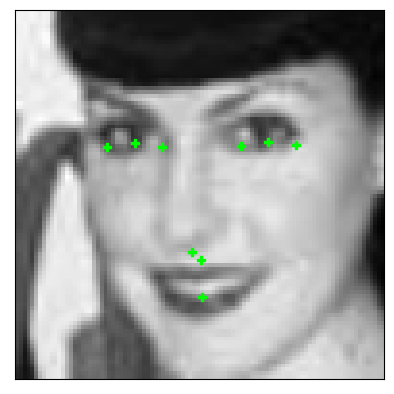

In [27]:
plot_image(faces, landmarks, random.randint(3000,7000))

5699


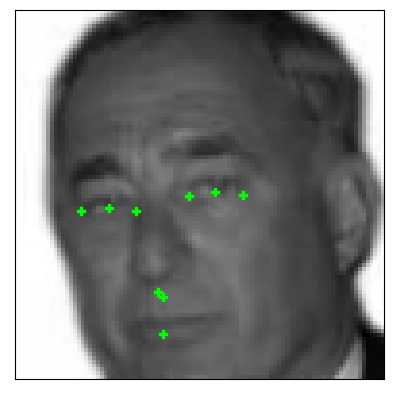

In [28]:
plot_image(faces, landmarks, 5699)

Neke točke nisu najpreciznije označene, ali to je nedostatak izračunavanja nedostajućih vrijednosti u datasetu i sa tim ćemo morati živjeti.

In [21]:
def plot_mult_images(image_array, landmarks, rows = 3, cols = 3):
    default_pics = [random.randint(3000,7000) for i in range(rows*cols)]
    pic_size = 96
    index = 0

    fig, ax = plt.subplots(rows,cols,sharex=True,sharey=True,figsize=[cols*2,rows*2])
    for row in range(rows):
        for col in range(cols):
            ax[row,col].imshow(image_array[default_pics[index]], cmap='gray')
            ax[row,col].scatter(landmarks.iloc[default_pics[index],0::2], landmarks.iloc[default_pics[index],1::2], c="#0f0", marker='+')
            ax[row,col].set_xticks(())
            ax[row,col].set_yticks(())
            ax[row,col].set_title('image index = %d' %(default_pics[index]),fontsize=10)
            index += 1

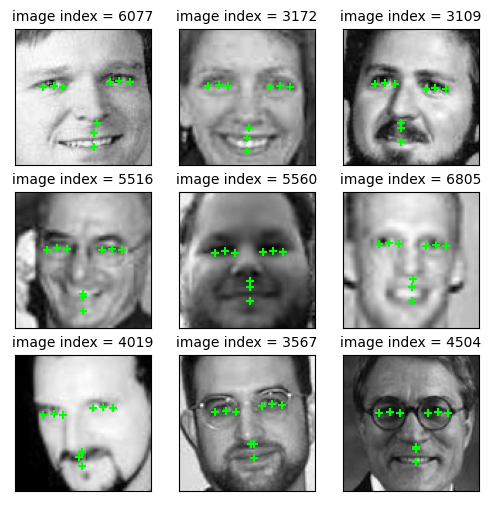

In [29]:
plot_mult_images(faces, landmarks)

## Model

Priprema podataka za treniranje modela.

In [33]:
print(f"faces.shape     -> {faces.shape}")
print(f"landmarks.shape -> {landmarks.shape}")
train_x,test_x,train_y,test_y = train_test_split(faces, landmarks, test_size=0.2, random_state=42)

print(f"\ntrain_x.shape -> {train_x.shape}")
print(f"train_y.shape -> {train_y.shape}")
print(f"test_x.shape  -> {test_x.shape}")
print(f"test_y.shape  -> {test_y.shape}")



faces.shape     -> (7000, 96, 96, 1)
landmarks.shape -> (7000, 18)

train_x.shape -> (5600, 96, 96, 1)
train_y.shape -> (5600, 18)
test_x.shape  -> (1400, 96, 96, 1)
test_y.shape  -> (1400, 18)


In [49]:
img_size=96

model=Sequential()

model.add(Input(shape=(img_size, img_size, 1)))

model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding="same"))#, kernel_initializer=he_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding="same"))#, kernel_initializer=he_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Conv2D(512, (3,3), padding="same"))#, kernel_initializer=he_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
# model.add(Dense(256, kernel_initializer=he_uniform(), activation=LeakyReLU(0.1)))
model.add(Dense(512, activation=LeakyReLU(0.1)))
model.add(Dropout(0.4))
# model.add(Dense(64, kernel_initializer=he_uniform(), activation=LeakyReLU(0.1)))
model.add(Dense(64, activation=LeakyReLU(0.1)))

model.add(Dense(18))#,kernel_initializer=he_uniform()))


model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mean_squared_error'])

In [26]:
model.summary()                      

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 96, 96, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       1

### Model visualisation

In [30]:
import visualkeras

# visualkeras.layered_view(model, to_file='model_300epochs_128batch_visualisation.png', legend=True).show() # write and show

In [31]:
import graphviz
import pydot

# tf.keras.utils.plot_model(
#     model,
#     to_file="model_300_128_visualisation2.png",
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=True,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=True)

In [32]:
# from ann_visualizer.visualize import ann_viz

# ann_viz(model, 
#     view=True, 
#     filename="model_300_128_visualisation3.png", 
#     title="Model visualisation")

### Treniranje modela

In [50]:

history = model.fit(
    x = train_x, 
    y = train_y,
    batch_size = 128,
    epochs = 60,
    validation_data = (test_x, test_y))


model.save('model_temp.h5')
with open('history_temp', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)


Epoch 1/60
44/44 [==============================] - 157s 4s/step - loss: 1612.6497 - mean_squared_error: 1612.6497 - val_loss: 2333.8535 - val_mean_squared_error: 2333.8535
Epoch 2/60
44/44 [==============================] - 157s 4s/step - loss: 617.9309 - mean_squared_error: 617.9309 - val_loss: 1605.5005 - val_mean_squared_error: 1605.5005
Epoch 3/60
44/44 [==============================] - 148s 3s/step - loss: 329.2070 - mean_squared_error: 329.2070 - val_loss: 940.9252 - val_mean_squared_error: 940.9252
Epoch 4/60
44/44 [==============================] - 143s 3s/step - loss: 224.8630 - mean_squared_error: 224.8630 - val_loss: 558.0217 - val_mean_squared_error: 558.0217
Epoch 5/60
44/44 [==============================] - 145s 3s/step - loss: 191.4231 - mean_squared_error: 191.4231 - val_loss: 369.4090 - val_mean_squared_error: 369.4090
Epoch 6/60
44/44 [==============================] - 144s 3s/step - loss: 169.5139 - mean_squared_error: 169.5139 - val_loss: 274.2195 - val_mean_squa

In [ ]:
#model.save('model.h5')

---

In [38]:
# model = load_model('model_300epochs_128batch.h5')
model = load_model('model_300epochs_128batch.h5')
with open('history_60_128_goodgraph', 'rb') as file_pi:
    history = pickle.load(file_pi)

In [52]:
history = history.history

---

In [53]:
model.evaluate(test_x, test_y)

44/44 [==============================] - 2s 52ms/step - loss: 33.4111 - mean_squared_error: 33.4111


[33.411075592041016, 33.411075592041016]

Možemo prikazati graf smanjenja greške predikcije kroz epohe.  

Text(0.5, 1.0, 'Loss Curves')

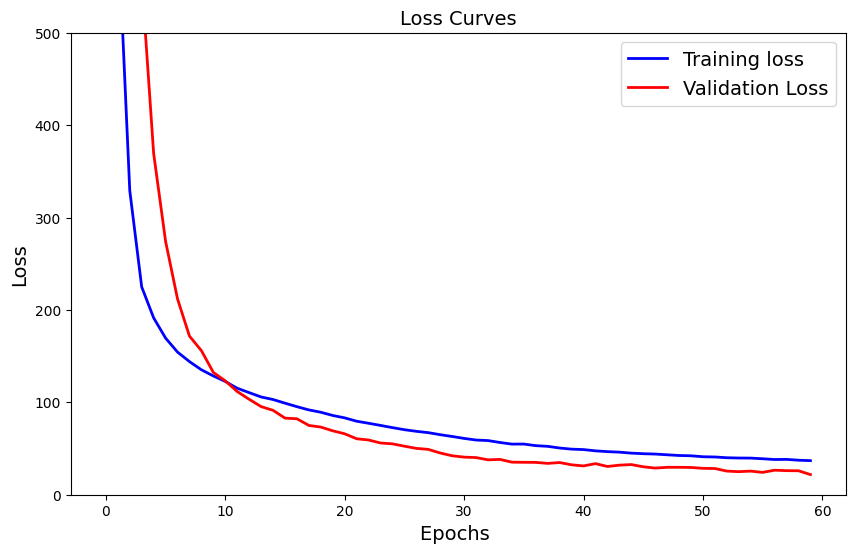

In [40]:

# history_dict = json.load(open('model_history_temp.json', 'r'))


plt.figure(figsize=[10,6])
plt.plot(history['loss'],'b',linewidth=2.0)
plt.plot(history['val_loss'],'r',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'], fontsize=14)
plt.ylim(0, 500)
plt.xlabel('Epochs ',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.title('Loss Curves',fontsize=14)


In [41]:
y_pred = model.predict(test_x)

44/44 [==============================] - 3s 56ms/step


In [42]:
def plot_predicted_image(images, truth, prediction, index):
    print(index, "->" , prediction[index])
    plt.imshow(images[index], cmap='gray')
    plt.scatter(truth.iloc[index, 0::2], truth.iloc[index, 1::2], c="#0f0", marker='P')
    plt.scatter(prediction[index, 0::2], prediction[index, 1::2], c="#f00", marker='P')
    plt.legend(["Truth","Prediction"])
    plt.show()

Usporedimo predicted sliku s originalnom slikom.


10 -> [62.17529  34.789505 27.809124 34.098892 54.3355   35.32407  67.40363
 35.086815 33.898262 35.414333 21.238625 35.059498 43.773006 58.59295
 44.468723 62.466133 43.551132 72.13192 ]


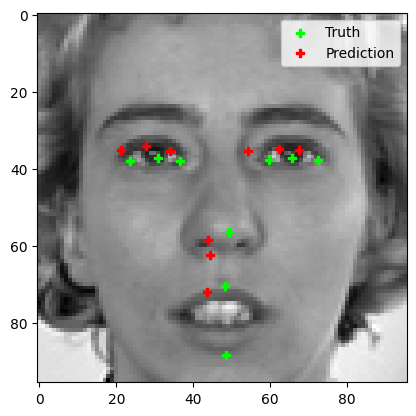

In [43]:
plot_predicted_image(test_x, test_y, y_pred, 10)

In [109]:
def plot_predicted_images(images, truth, prediction, with_truth=False, random = True):
    prediction = [851, 866, 142, 1241, 1171, 651, 1376, 89, 139]
    prediciton_truth = [73, 501, 277, 189, 644, 399, 679, 864, 452]

    if random:
        random_indexes = [random.randint(0, len(test_x))-1 for i in range(9)]


    rows = 3
    cols = 3

    arr_i = 0
    fig, ax = plt.subplots(rows,cols,sharex=True,sharey=True,figsize=[cols*2,rows*2])
    for row in range(rows):
        for col in range(cols):
            index = indexes[arr_i]
            ax[row,col].imshow(images[index], cmap='gray')
            if with_truth:
                ax[row,col].scatter(truth.iloc[index, 0::2], truth.iloc[index, 1::2], c="#0f0", marker='+')
            ax[row,col].scatter(prediction[index, 0::2], prediction[index, 1::2], c="#f00", marker='+')
            # ax[row,col].set_xticks(())
            # ax[row,col].set_yticks(())
            ax[row,col].set_title('image index = %d' %(index),fontsize=10)
            arr_i += 1

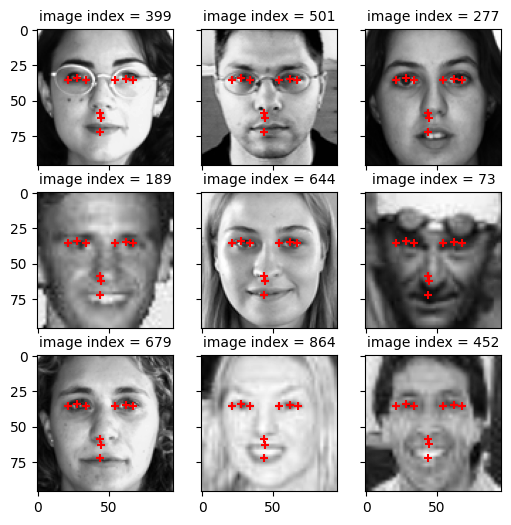

In [111]:
#random_indexes = [random.randint(0, len(test_x))-1 for i in range(9)]
plot_predicted_images(test_x, test_y, y_pred, with_truth=False,)#, random_indexes)

neka sprobavanja...

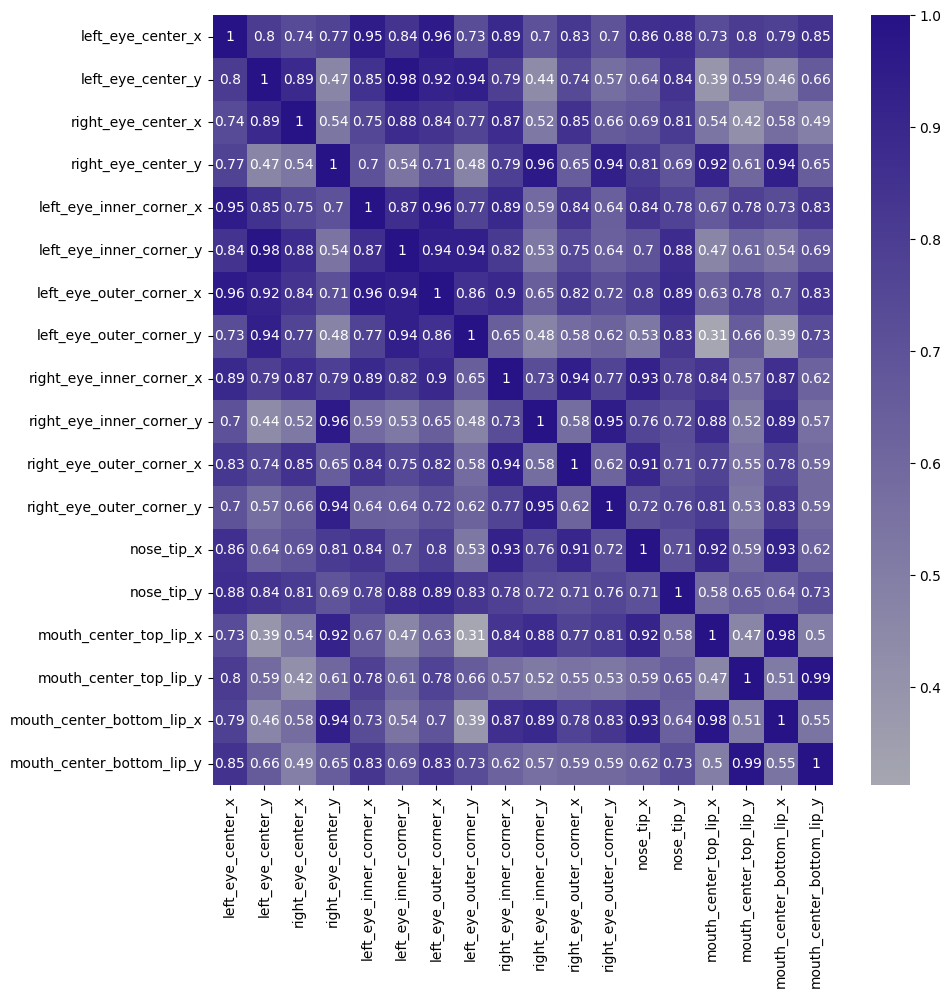

In [44]:
landmarks_trained = pd.DataFrame(y_pred, columns=landmarks.columns)
landmarks_trained.head()
plt.figure(figsize=(10,10))
sns.heatmap(landmarks_trained.corr(), cmap=sns.color_palette("blend:#A5A6B1,#271286", as_cmap=True), annot=True)
plt.show()